# Final Classification Model

The **purpose** of this notebook is to build a model that can accurately classify whether a TikTok video presents a "claim" or presents an "opinion".

The **goal** of the model is to increase response time and system efficiency by automating the initial stages of the claims process.

---

*This activity has six parts:*

**Part 1:** Business Needs and Ethical Implications

**Part 2:** Imports and EDA

**Part 3:** Feature Engineering

**Part 4:** Build Model

**Part 5:** Evaluate Model

**Part 6:** Conclusion

## Part 1: Business Needs and Ethical Implications

### Business Needs and Objective

TikTok users can report videos that they believe violate the platform's terms of service. Since there are millions of videos created and viewed by users everyday, there is also a lot of videos getting reported everyday as well. The amount is too much to be individually reviewed by human moderators.

Therefore, TikTok needs an accurate predictive model that determines whether a video contains a claim or an opinion. By building the model, we can reduce the backlog of user reports and prioritize them more efficiently. For example, videos classified as claims by the model will be ranked by how many reports the video received. Then the top x% of the reports will be reviewed by human moderators.

### Ethical Implications and Consequences of Errors
There is no perfect model that makes no mistakes. There is always going to be some bias and error in the model. Therefore, it's important to consider the consequences of the errors. Since we are going to build a classification model, there is two types of errors we need to consider:
- False positives: When the model predicts a video is a claim when in fact it is an opinion
- False negatives: When the model predicts a video is an opinion when in fact it is a claim

The worst case for false positive is that a opinion video classified as claim gets send to a human moderator for review. The consequence of this error is small. The worst case for false negative is a claim video classified as opinion does not get reviewed by a human moderator. The consequence of this error is a video that violates the terms of service is overlooked.

Therefore, we need to build a model that focuses on minimizing false negative which means the model should have high recall score. The data team decided to build a model using random forest and split the data into train/validation/test sets (60/20/20).

## Part 2: Imports and EDA

In [46]:
# Import packages for data manipulation
import numpy as np
import pandas as pd

# Import packages for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Import packages for data modeling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance

In [47]:
sns.set_theme()
sns.set_palette('colorblind')

In [48]:
# Load dataset into dataframe
data = pd.read_csv('data/tiktok_dataset.csv')

In [49]:
# Display first few rows
data.head()

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0


In [50]:
# Get number of rows and columns
data.shape

(19382, 12)

In [51]:
# Get data types of columns
data.dtypes

#                             int64
claim_status                 object
video_id                      int64
video_duration_sec            int64
video_transcription_text     object
verified_status              object
author_ban_status            object
video_view_count            float64
video_like_count            float64
video_share_count           float64
video_download_count        float64
video_comment_count         float64
dtype: object

In [52]:
# Get basic information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19382 entries, 0 to 19381
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   #                         19382 non-null  int64  
 1   claim_status              19084 non-null  object 
 2   video_id                  19382 non-null  int64  
 3   video_duration_sec        19382 non-null  int64  
 4   video_transcription_text  19084 non-null  object 
 5   verified_status           19382 non-null  object 
 6   author_ban_status         19382 non-null  object 
 7   video_view_count          19084 non-null  float64
 8   video_like_count          19084 non-null  float64
 9   video_share_count         19084 non-null  float64
 10  video_download_count      19084 non-null  float64
 11  video_comment_count       19084 non-null  float64
dtypes: float64(5), int64(3), object(4)
memory usage: 1.8+ MB


In [53]:
# Generate basic descriptive stats
data.describe()

,#,video_id,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
count,19382.000000,1.938200e+04,19382.000000,19084.000000,19084.000000,19084.000000,19084.000000,19084.000000
mean,9691.500000,5.627454e+09,32.421732,254708.558688,84304.636030,16735.248323,1049.429627,349.312146
std,5595.245794,2.536440e+09,16.229967,322893.280814,133420.546814,32036.174350,2004.299894,799.638865
min,1.000000,1.234959e+09,5.000000,20.000000,0.000000,0.000000,0.000000,0.000000
25%,4846.250000,3.430417e+09,18.000000,4942.500000,810.750000,115.000000,7.000000,1.000000
50%,9691.500000,5.618664e+09,32.000000,9954.500000,3403.500000,717.000000,46.000000,9.000000
75%,14536.750000,7.843960e+09,47.000000,504327.000000,125020.000000,18222.000000,1156.250000,292.000000
max,19382.000000,9.999873e+09,60.000000,999817.000000,657830.000000,256130.000000,14994.000000,9599.000000


In [54]:
# Check for missing values
data.isna().sum()

#                             0
claim_status                298
video_id                      0
video_duration_sec            0
video_transcription_text    298
verified_status               0
author_ban_status             0
video_view_count            298
video_like_count            298
video_share_count           298
video_download_count        298
video_comment_count         298
dtype: int64

In [55]:
# Drop rows with missing values
data = data.dropna()

In [56]:
# Display first few rows after handling missing values
data.head()

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0


In [57]:
# Check for duplicates
data.duplicated().sum()

0

In [58]:
# Check class balance
data['claim_status'].value_counts(normalize=True)

claim_status
claim      0.503458
opinion    0.496542
Name: proportion, dtype: float64

## Part 3: Feature Engineering

In [59]:
# Extract the length of each `video_transcription_text` and add this as a column to the dataframe
data['transcription_length'] = data['video_transcription_text'].map(len)

In [60]:
# Display first few rows of dataframe after adding new column
data.head()

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,transcription_length
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0,97
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0,107
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0,137
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0,131
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0,128


In [61]:
## Calculate the average text_length for claims and opinions.
data.groupby('claim_status')[['transcription_length']].mean()

,transcription_length
claim_status,
claim,95.376978
opinion,82.722562


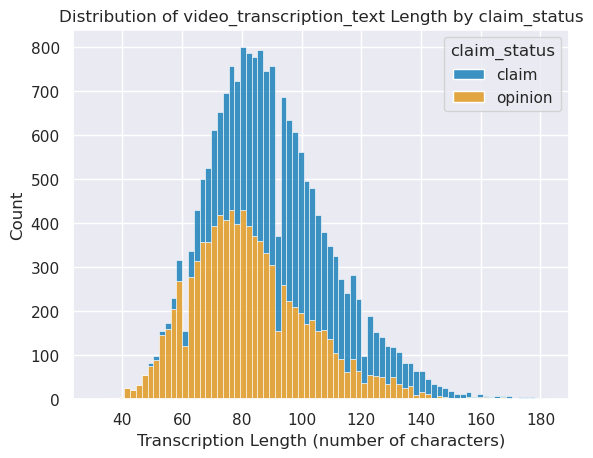

In [62]:
# Visualize the distribution of `video_transcription_text` length for claims and opinions
# Create two histograms in one plot
fig, ax = plt.subplots()
sns.histplot(data=data, x='transcription_length', hue='claim_status', multiple='stack', ax=ax)
ax.set_xlabel('Transcription Length (number of characters)')
plt.title("Distribution of video_transcription_text Length by claim_status")

plt.show()

### Feature Selection and Transformation

In [63]:
# Select outcome variable
y = data['claim_status']

# Encode target and categorical variables
y = y.replace({'opinion':0, 'claim':1})
y

0        1
1        1
2        1
3        1
4        1
        ..
19079    0
19080    0
19081    0
19082    0
19083    0
Name: claim_status, Length: 19084, dtype: int64

In [64]:
# Select features variables
X = data.drop(['#', 'video_id', 'claim_status', 'video_transcription_text'], axis=1)

# Get dummy variables for categorical data
X = pd.get_dummies(X, columns=['verified_status','author_ban_status'], drop_first=True)
X.head()

,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,transcription_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review
0,59,343296.0,19425.0,241.0,1.0,0.0,97,False,False,True
1,32,140877.0,77355.0,19034.0,1161.0,684.0,107,False,False,False
2,31,902185.0,97690.0,2858.0,833.0,329.0,137,False,False,False
3,25,437506.0,239954.0,34812.0,1234.0,584.0,131,False,False,False
4,19,56167.0,34987.0,4110.0,547.0,152.0,128,False,False,False


## Part 4: Build Model

### Split the Data
Create train/validate/test sets.

In [65]:
# Split data into training and testing sets (80/20).
X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [66]:
# Split the training set into training and validation sets (75/25), to result in a final ratio of 60/20/20 for train/validate/test sets.
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, test_size=0.25, random_state=42)

In [67]:
# Confirm that the dimensions of the training, validation, and testing sets are in alignment.
print(f'X_train = {X_train.shape} \t X_val = {X_val.shape} \t X_test = {X_test.shape}')
print(f'y_train = {y_train.shape} \t y_val = {y_val.shape} \t y_test = {y_test.shape}')

X_train = (11450, 10) 	 X_val = (3817, 10) 	 X_test = (3817, 10)
y_train = (11450,) 	 y_val = (3817,) 	 y_test = (3817,)


### Build Random Forest Model
Fit a random forest model to the training set. Use cross-validation to tune the hyperparameters and select the model that performs best on recall.

In [68]:
# Instantiate the random forest classifier
rf = RandomForestClassifier(random_state=42)

# Create a dictionary of hyperparameters to tune
rf_cv_params = {'n_estimators':[50, 100, 150],
                'max_depth':[3, 5, None],
                'min_samples_leaf':[1, 2],
                'min_samples_split': [2, 3, 4],
                'max_features':['sqrt', 'log2', 0.6]}

# Define a dictionary of scoring metrics to capture
scoring = ['accuracy', 'precision', 'recall', 'f1']

# Instantiate the GridSearchCV object
rf_cv = GridSearchCV(rf, param_grid=rf_cv_params, scoring=scoring, cv=5, refit='recall')

In [69]:
%%time
rf_cv.fit(X_train, y_train)

CPU times: user 8min 16s, sys: 661 ms, total: 8min 17s
Wall time: 8min 17s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [3, 5, None],
                         'max_features': ['sqrt', 'log2', 0.6],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [50, 100, 150]},
             refit='recall', scoring=['accuracy', 'precision', 'recall', 'f1'])

In [70]:
# Examine best recall score
rf_cv.best_score_

0.9915490464431287

In [71]:
# Examine best parameters
rf_cv.best_params_

{'max_depth': None,
 'max_features': 0.6,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 50}

In [72]:
# Get all the results from the CV and put them in a df
rf_results = pd.DataFrame(rf_cv.cv_results_)

# Isolate the row of the df with the max mean recall score
rf_best_estimator_results = rf_results.iloc[rf_results['mean_test_recall'].idxmax()].to_frame(name='Random Forest CV').transpose()
rf_best_estimator_results = rf_best_estimator_results[['mean_test_accuracy', 'mean_test_precision',
                                                       'mean_test_recall', 'mean_test_f1']]

rf_best_estimator_results

,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1
Random Forest CV,0.995459,0.999479,0.991549,0.995497


Based on the scores, the model performs exceptionally well with a average recall score of 0.99. The model is almost making perfect predictions and we don't need to worry about if it's overfitting since we used cross-validation.

### Build XGBoost model

In [73]:
# Instantiate the XGBoost classifier
xgb = XGBClassifier(objective='binary:logistic', random_state=42)

# Create a dictionary of hyperparameters to tune
xgb_cv_params = {'n_estimators':[50, 75, 100],
                 'max_depth':[3, 4, 5, None],
                 'learning_rate':[0.01, 0.05, 0.1]}

# Define a dictionary of scoring metrics to capture
scoring = ['accuracy', 'precision', 'recall', 'f1']

# Instantiate the GridSearchCV object
xgb_cv = GridSearchCV(xgb, xgb_cv_params, scoring=scoring, cv=5, refit='recall')

In [74]:
%%time
xgb_cv.fit(X_train, y_train)

CPU times: user 3min 41s, sys: 1.45 s, total: 3min 42s
Wall time: 30 s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=42, ...),
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 4, 5, None],
                         'n_estimators': [50, 75, 100]},
             refit='recall', scoring=['accuracy', 'precision', 'recall', 'f1'])

In [75]:
xgb_cv.best_score_

0.9917214602362321

In [76]:
xgb_cv.best_params_

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}

In [77]:
# Get all the results from the CV and put them in a df
xgb_results = pd.DataFrame(xgb_cv.cv_results_)

# Isolate the row of the df with the max (mean recall score)
xgb_best_estimator_results = xgb_results.iloc[xgb_results['mean_test_recall'].idxmax()].to_frame(name='XGBoost').transpose()
xgb_best_estimator_results = xgb_best_estimator_results[['mean_test_accuracy', 'mean_test_precision',
                                                       'mean_test_recall', 'mean_test_f1']]

xgb_best_estimator_results

,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1
XGBoost,0.995808,1.0,0.991721,0.995843


In [78]:
# Put results from random forest and XGBoost into a table and compare
results_table = pd.concat([rf_best_estimator_results, xgb_best_estimator_results])
results_table

,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1
Random Forest CV,0.995459,0.999479,0.991549,0.995497
XGBoost,0.995808,1.0,0.991721,0.995843


Both models perform exceptionally well and have similar scores. XGBoost performs slightly better.

## Part 5: Evaluate Model
Evaluate models against validation criteria.

### Evaluate Random forest

In [79]:
# Use the random forest "best estimator" model to get predictions on the validation set
rf_y_pred = rf_cv.best_estimator_.predict(X_val)

In [80]:
# Display the predictions on the validation set
rf_y_pred

array([1, 0, 0, ..., 0, 0, 1])

In [81]:
# Display the true labels of the validation set
y_val

1871     1
16574    0
17741    0
17214    0
17821    0
        ..
15929    0
12177    0
18295    0
17339    0
9186     1
Name: claim_status, Length: 3817, dtype: int64

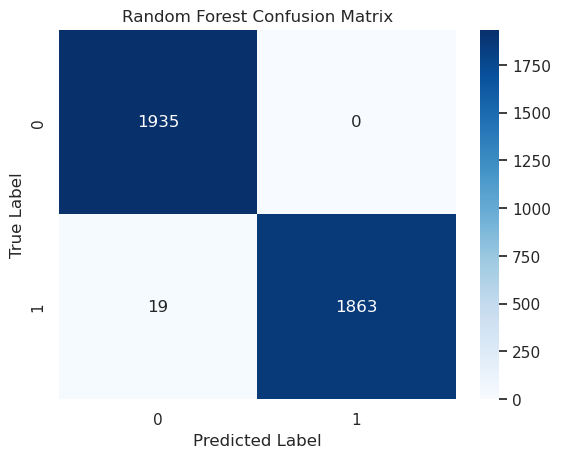

In [82]:
# Create a confusion matrix to visualize the results of the classification model

# Compute values for confusion matrix
rf_cm = confusion_matrix(y_val, rf_y_pred)

# Create display of confusion matrix
fig, ax = plt.subplots()
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_title('Random Forest Confusion Matrix')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')

# Plot confusion matrix
plt.show()

In [83]:
# Create a classification report for random forest model
print(classification_report(y_val, rf_y_pred, target_names=['opinion','claim']))

              precision    recall  f1-score   support

     opinion       0.99      1.00      1.00      1935
       claim       1.00      0.99      0.99      1882

    accuracy                           1.00      3817
   macro avg       1.00      0.99      1.00      3817
weighted avg       1.00      1.00      1.00      3817



Based on the confusion matrix and the scores, the model performed almost perffectly on the validation set as well. The model classified opinions perfectly and misclassified 19 claims as opininos.

### Evaluate XGBoost

In [84]:
# Evaluate XGBoost model
xgb_y_pred = xgb_cv.best_estimator_.predict(X_val)

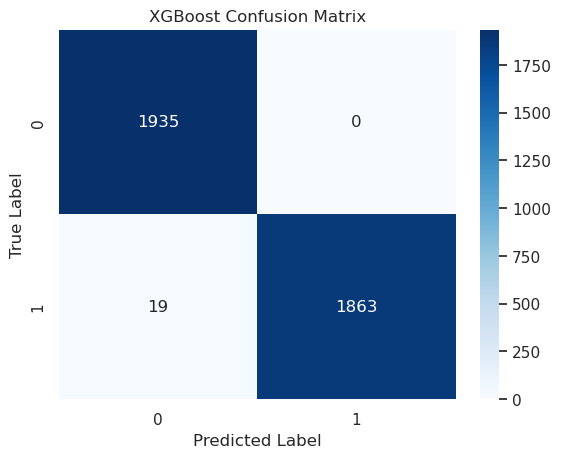

In [85]:
# Compute values for confusion matrix
xgb_cm = confusion_matrix(y_val, xgb_y_pred)

# Create display of confusion matrix
fig, ax = plt.subplots()
sns.heatmap(xgb_cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_title('XGBoost Confusion Matrix')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')

# Plot confusion matrix
plt.show()

In [86]:
# Create a classification report
print(classification_report(y_val, xgb_y_pred, target_names=['opinion', 'claim']))

              precision    recall  f1-score   support

     opinion       0.99      1.00      1.00      1935
       claim       1.00      0.99      0.99      1882

    accuracy                           1.00      3817
   macro avg       1.00      0.99      1.00      3817
weighted avg       1.00      1.00      1.00      3817



It seems like XGBoost performed the same as the random forest model. It also classified opinions perfectly and misclassified 19 claims as opininos.

### Use Best Model to Predict on Test Data
Since both random forest and XGBoost perform similarly well, I will just go with random forest.

In [87]:
# Get predictions on the test set
y_pred = rf_cv.best_estimator_.predict(X_test)

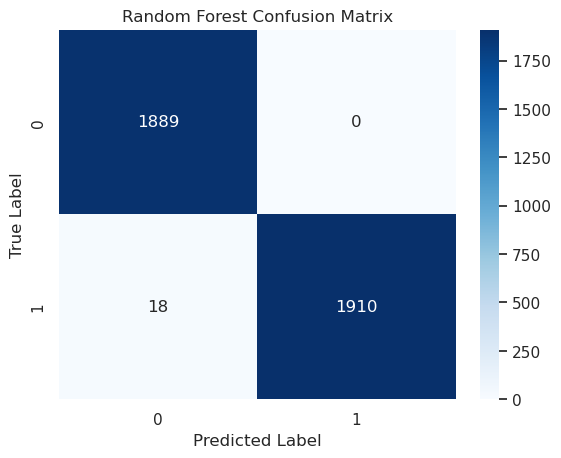

In [88]:
# Compute values for confusion matrix
rf_cm = confusion_matrix(y_test, y_pred)

# Create display of confusion matrix
fig, ax = plt.subplots()
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_title('Random Forest Confusion Matrix')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')

# Plot confusion matrix
plt.show()

### Best Model Feature Importance

In [89]:
# Get feature importance
importances = rf_cv.best_estimator_.feature_importances_
importances = pd.Series(importances, index=X_test.columns).to_frame(name='importance').reset_index(names='feature')
importances

,feature,importance
0,video_duration_sec,0.001399
1,video_view_count,0.641917
2,video_like_count,0.263122
3,video_share_count,0.069819
4,video_download_count,0.019561
5,video_comment_count,0.001792
6,transcription_length,0.001843
7,verified_status_verified,0.000011
8,author_ban_status_banned,0.000428
9,author_ban_status_under review,0.000107


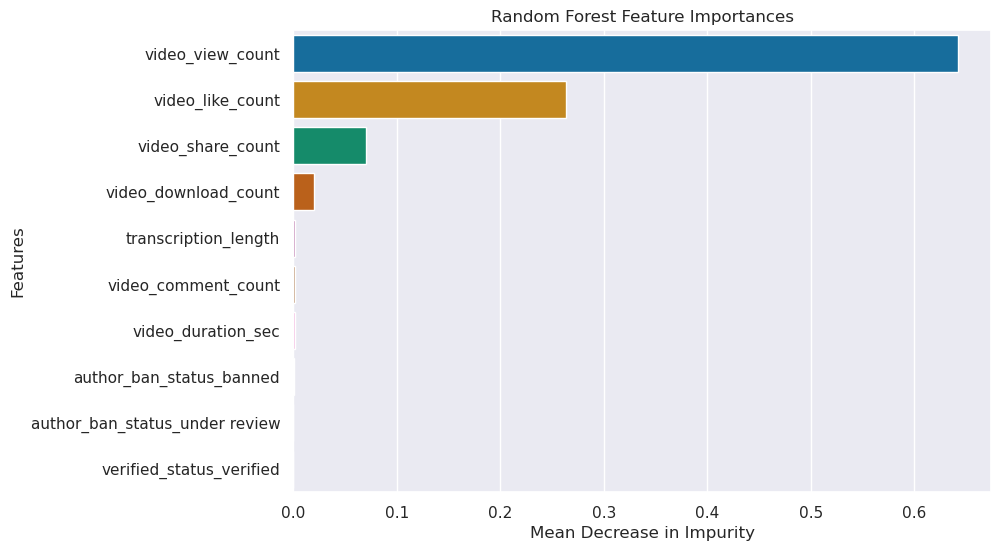

In [90]:
# Graph feature importance on a barplot
importances = rf_cv.best_estimator_.feature_importances_
importances = pd.Series(importances, index=X_test.columns).to_frame(name='importance').reset_index(names='feature')
importances.sort_values(by='importance', ascending=False, inplace=True)

fig, ax = plt.subplots(figsize=(9,6))
sns.barplot(data=importances, y='feature', x='importance', ax=ax)
ax.set_title('Random Forest Feature Importances')
ax.set_xlabel('Mean Decrease in Impurity')
ax.set_ylabel('Features')

plt.show()

Based on feature importance, the most predictive features are `video_view_count`, `video_like_count`, and `video_share_count`.

These predictive features are all related to engagement levels generated by the video. This is expected because from prior EDA, we saw that claims videos are generally more popular and generates more views.

## Part 6: Conclusion

**Business needs and objective:** Build an accurate predictive model that determines whether a video contains a claim or an opinion to reduce the backlog of user reports and prioritize them more efficiently.

Based on model performance, we can confidently say that we have successfully achieved our objective! The model performed exceptionally well (almost perfect - 99% accuracy) on both the validation and test set.

The next step would be to test the model on more data to make sure that model performance stay relatively the same before deploying the model. 